In [1]:
# demo de-noising using fhmm
# this is attempt 2,
# use HDP pickles and a new HDP during decoding

import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/final/tests', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [2]:
import librosa
import torchaudio
import numpy as np
import config
import os.path
import math
import os
import pathlib
import random
import torch
import utils
import warnings
import my_torch.torchio as tio
import torchaudio.functional as F
import torchaudio.transforms as T

In [3]:
from whale.setup import get_data, constants, annotations
import importlib
importlib.reload(constants)

importlib.reload(get_data)
from final import useful
importlib.reload(useful)

HUMPBACK = 'humpback'
BOWHEAD = 'bowhead'
NOISE = 'noise'

# constants for fe and what not
fs = 4000
nfft = 256

signal_types = [HUMPBACK, BOWHEAD, NOISE]

# type to label
signal_types_labels = {
    HUMPBACK: 0,
    BOWHEAD: 1,
    NOISE: 2
}

# label to type
label_to_type = {
    0: HUMPBACK,
    1: BOWHEAD,
    2: NOISE
}

get_data_dict = {
    HUMPBACK: [get_data.GetDataSimple(constants.HUMPBACK_WAV_A,constants.SWOOPS_LABELS_A, fs, useful.file_to_audio)],
    BOWHEAD: [get_data.GetDataSimple(constants.BOWHEAD_AUDIO,constants.BOWHEAD_LABELS_WHALE, fs, useful.file_to_audio)],
    NOISE: [get_data.GetDataSimple(constants.HUMPBACK_WAV_A,constants.HUMPBACK_LABEL_A_NOISE, fs, useful.file_to_audio),
            get_data.GetDataSimple(constants.BOWHEAD_AUDIO,constants.BOWHEAD_LABELS_NOISE, fs, useful.file_to_audio)]
}

samples, labels = useful.get_samples(get_data_dict, signal_types, signal_types_labels)


__collected samples__
humpback :  18
bowhead :  34
noise :  62


In [4]:
# separate using cross-validation
import final.cross_validation as cv
from final.cross_validation import *
import importlib
importlib.reload(cv)

n_folds = 2
cv_output = cv.split_data_for_cross_validation(samples, labels, n_folds, test_ratio=0.2)

In [5]:
cv_index = 0    # select train and test for this iteration
importlib.reload(useful)
train = useful.SampleHolder(cv_output[TRAIN_DATA][cv_index], cv_output[TRAIN_LABEL][cv_index])
val = useful.SampleHolder(cv_output[VAL_DATA][cv_index], cv_output[VAL_LABEL][cv_index])
test = useful.SampleHolder(cv_output[TEST_DATA], cv_output[TEST_LABEL])


In [6]:
# average power for each label
import noisey

def show_avg_powers(list_of_labels, sample_holder):
    for lab in list_of_labels:
        indices = sample_holder.sample_labels == lab
        samps = [item for item, condition in zip(sample_holder.samples, indices) if condition]
        avg_power = noisey.get_signal_avg_db(np.concatenate(samps))
        avg_power_v2 = utils.get_average_power(np.concatenate(samps), use_buffer=True)
        print('label: ', lab, ' | avg power: ', avg_power, ' | v2: ',  10 * np.log10(avg_power_v2))

show_avg_powers(np.array([0,1,2]), val)

label:  0  | avg power:  -15.867737531661987  | v2:  -15.897210425448826
label:  1  | avg power:  -16.95154309272766  | v2:  -16.958811450469142
label:  2  | avg power:  -30.92646837234497  | v2:  -30.93816090852069


In [7]:
# save pickle for else where
# import pickle
# print("Writing to pickle file: " + 'train-test-val' + ".pkl")
# output = open('train-test-val' + ".pkl", "wb")
# pickle.dump({'train': train, 'val':val, 'test':test}, output)
# output.close()

In [8]:
def get_mfcc_feature(sample, fs, nfft):
    return librosa.feature.mfcc(y=sample,sr=fs,n_mfcc=13,kwargs={'nfft': nfft})

In [9]:
def get_feature(samp):
    # add optionals here if needed
    # mfcc
    # feat = librosa.feature.mfcc(y=samp,sr=4000,n_mfcc=13).T
    feat = useful.get_log_power_feature(samp, nfft=128)
    return feat

# Train

In [10]:
# train hmms
from hmmlearn.hmm import GaussianHMM
#
# hmms = {
#     HUMPBACK: GaussianHMM(5),
#     BOWHEAD: GaussianHMM(5),
#     NOISE: GaussianHMM(4)
# }
#
train.features = []
for sample in train.samples:
    train.features.append(get_feature(sample))

Hmm_learn_noise = GaussianHMM(4)

# for key in hmms:
#     cur_hmm = hmms[key]
feat_indicis = train.sample_labels == signal_types_labels[NOISE]
hmm_features = [item for item, condition in zip(train.features, feat_indicis) if condition]
Hmm_learn_noise.fit(np.concatenate(hmm_features))

# pickles !

import pickle

with open('/Users/david/Documents/mastersCode/ubm/final/models/hdphmm/hdphmmwl/testing/HumpbackWhaleHMM.pkl', 'rb') as file:
    humpback_hmm = pickle.load(file)

with open('/Users/david/Documents/mastersCode/ubm/final/models/hdphmm/hdphmmwl/testing/BowheadWhaleHMM.pkl', 'rb') as file:
    bowhead_hmm = pickle.load(file)

with open('/Users/david/Documents/mastersCode/ubm/final/models/hdphmm/hdphmmwl/testing/NoiseWhaleHMM.pkl', 'rb') as file:
    noise_hmm = pickle.load(file)

hmms = {
    HUMPBACK: humpback_hmm,
    BOWHEAD: bowhead_hmm,
    NOISE: Hmm_learn_noise,
}


In [11]:
# check / update hmms
importlib.reload(useful)
print(useful.find_similar_states_kl(hmms[BOWHEAD], hmms[NOISE], n_samples=10))

[[161.22077688  24.38332674  35.08897194  23.26067642]
 [153.53082278  31.51495809  37.6480928   35.217052  ]
 [209.78950242  45.21909232  52.19943975  61.32490222]
 [162.86861182  34.93686013  46.28132515  37.14454676]
 [195.99164051  52.84768094  66.23464804  59.64343199]
 [ 90.43820965   2.08721572  11.94113639   6.04361287]
 [185.52489129  38.96696286  41.64136884  41.54047075]
 [189.8187449   39.21569996  44.87403692  39.51996705]]


In [12]:
hmm_bowhead_updated = useful.delete_component(hmms[BOWHEAD], 5)
print(useful.find_similar_states_kl(hmm_bowhead_updated, hmms[NOISE], n_samples=10))
hmms[BOWHEAD] = hmm_bowhead_updated

deleting comp 5
[[159.90500556  25.96070612  31.18348962  30.75814607]
 [145.98805643  32.36352501  32.78729203  34.04493841]
 [190.89228327  51.64099288  46.19421267  53.33139522]
 [158.86774654  37.0536748   44.86829312  35.32564402]
 [212.11255315  46.42092643  65.9069478   64.80959425]
 [190.81285337  31.39275525  33.30116443  53.42447863]
 [193.76209319  35.86467033  39.23670244  34.97076453]]


In [32]:
print(useful.find_similar_states_kl(hmms[HUMPBACK], hmms[NOISE]))

[[129.41475628 255.92629292 126.938062   327.48852771]
 [195.79093741  91.17229216 189.11831374 115.68843852]
 [ 83.57904621  85.55553211  80.28939071 154.88881986]
 [102.17335956  73.82274833  92.59385797 116.43733816]
 [186.42086477 103.01551975 171.29182116 135.17668791]
 [125.24813508 123.21512179 146.33411288 199.50497798]
 [187.77711415  98.29645455 172.91950362 125.84216486]
 [ 15.64363571  67.06006097  14.0330607  153.0690623 ]
 [132.66676295  60.97243207 119.26929415 110.14934179]
 [176.65108904 110.41756447 159.72583038 143.89210934]
 [187.48388727  69.04439649 182.94997955 103.0791691 ]]


In [18]:
hmm_humpback_updated = useful.delete_component(hmms[HUMPBACK], 7)
print(useful.find_similar_states_kl(hmm_humpback_updated, hmms[NOISE]))
hmms[HUMPBACK] = hmm_humpback_updated

deleting comp 1
[[484.71272891 240.03363824 342.25813373 173.77788759]
 [533.13826709 302.83396627 221.96333558 200.42895578]
 [402.82697138 252.82348031 196.89635745 182.26355176]
 [429.81612412 211.41398524 128.02580672 159.26941916]]


In [13]:
# get accuracy measure then decode combine
import sklearn.metrics
import decode_combine as dc
importlib.reload(dc)
combined_model = dc.DecodeCombineGaussian([hmm for hmm in hmms.values()])

## Validation

In [14]:
# if validate has added noise or reverb add here

import noisey
import matplotlib.pyplot as plt
importlib.reload(noisey)

signal_avg_db = -16 # from inspection

def get_noise_for_sample(sig_db, sample, snr_1=30, snr_2=30, snr_3=30):
    noise_power_1 = noisey.get_noise_power_given_signal_avg_db(sig_db, snr_1)
    noise_power_2 = noisey.get_noise_power_given_signal_avg_db(sig_db, snr_2)
    noise_power_3 = noisey.get_noise_power_given_signal_avg_db(sig_db, snr_3)

    noise_sample, _ = noisey.generate_gaussian_noise(len(sample), noise_power_1, noise_power_2, noise_power_3)
    return noise_sample

# noise_example = add_noise_to_sample(signal_avg_db, samples[0])
# plt.plot(noise_example)
# plt.plot(samples[0])
# plt.show()
# noisey.get_signal_avg_db(noise_example)
# noisey.get_signal_avg_db(samples[5])
# def add_noise_to_sample(sample):

In [76]:
importlib.reload(useful)
val.features = []
noise_samples = []
noise_features = []
noise_features_v2 = []
for i in range(len(val.samples)):

    # ---- noise / reverb adjustments ---- START
    noise_sample = get_noise_for_sample(signal_avg_db, val.samples[i], 10, 8, 40)
    noise_samples.append(noise_sample)
    noise_features.append(get_feature(noise_sample))
    adjusted_sample = val.samples[i] + noise_sample
    # ---- noise / reverb adjustments ---- END

    feature = get_feature(adjusted_sample)
    if val.sample_labels[i] == 2:
        noise_features_v2.append(feature)
    val.features.append(feature)
val.update_feature_labels()

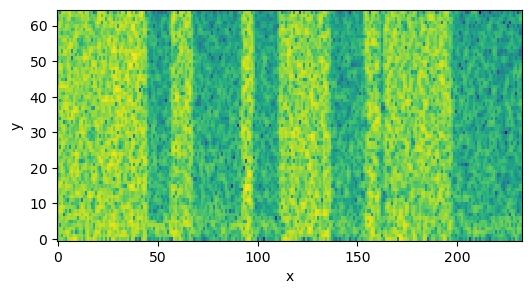

In [54]:
useful.vis_helper(noise_features_v2[20])

In [77]:
_, val_pred, val_log_prob = combined_model.decode_hmmlearn(np.concatenate(val.features))
accuracy = useful.perf_measure(np.concatenate(val.feature_labels), val_pred)
print(accuracy)
# 'ACC': 0.889, 'TPR': 0.941, 'FPR': 0.201      | 30 db snr
# 'ACC': 0.407, 'TPR': 0.271, 'FPR': 0.135      | 10 db snr

{'ACC': 0.39798850574712646, 'TPR': 0.25102717031146454, 'FPR': 0.09777171441564347, 'TNR': 0.9022282855843565, 'PPV': 0.8980559506875296, 'NPV': 0.2598559266535691, 'FNR': 0.7489728296885354, 'FDR': 0.10194404931247036}


In [78]:
# use HDP here
from hmmlearn.hmm import GaussianHMM
noise_hmm = GaussianHMM(4, covariance_type='diag', init_params='')
noise_hmm.fit(np.concatenate(noise_features))

noise_hmm_v2 = GaussianHMM(4, covariance_type='diag', init_params='')
noise_hmm_v2.fit(np.concatenate(noise_features_v2))

# what happens if I create HMM using noise samples ? :/

GaussianHMM(init_params='', n_components=4)

In [62]:
useful.find_similar_states_kl(noise_hmm_v2, hmms[NOISE], n_samples=10)

array([[122.64881163,  25.09698514,  30.49669684,  36.80698083],
       [326.34230544, 121.32774009, 107.25415406, 123.37547656],
       [ 70.72754772,   1.6273889 ,  11.86713839,   2.41873384],
       [  0.43083569,  87.41733803, 102.96928196, 126.90817641]])

In [79]:
# i want noise_hmm
# i have noise_hmm_v2 and hmms[NOISE]

noise_means = []
# assume noise was made up of max opperation
for i in range(noise_hmm_v2.n_components):
    mean_i = noise_hmm_v2.means_[i]
    curr_mean = []
    for j in range(hmms[NOISE].n_components):
        mean_i = noise_hmm_v2.means_[i]
        mean_j = hmms[NOISE].means_[j]
        m_mask = (mean_i > mean_j + 1) # this is the noise mean ?
        m_mask_indicis = np.where(m_mask)
        mean_n = np.zeros(len(mean_i)) # np.full(len(mean_i), np.NINF)
        mean_n[m_mask_indicis] = mean_i[m_mask_indicis]
        curr_mean.append(mean_n)
    reduced_mean = np.maximum.reduce(curr_mean)
    noise_means.append(reduced_mean)

new_noise_means = np.stack(noise_means)
zero_mask = np.where(new_noise_means == 0)
new_noise_means[zero_mask] = np.NINF
noise_hmm_v2.means_ = new_noise_means

In [28]:

def find_repeats(arrays):
    unique_arrays = []

    for arr in arrays:

        # Check if the array is not already in unique_arrays
        if len(unique_arrays) == 0:
            zero_mask = np.where(arr == 0)
            arr[zero_mask] = np.NINF
            unique_arrays.append(arr)
        else:
            found = False
            for i in range(len(unique_arrays)):
                if not found:
                    close = np.where((arr == unique_arrays[i]) & (arr != 0))
                    true_count = np.count_nonzero(close)
                    if true_count > 0:
                        zero_mask = np.where(arr == 0)
                        arr[zero_mask] = np.NINF
                        unique_arrays[i] = np.maximum(arr, unique_arrays[i])
                        found = True
            if not found:
                zero_mask = np.where(arr == 0)
                arr[zero_mask] = np.NINF
                unique_arrays.append(arr)

    return unique_arrays

# Example usage
array1 = np.array([0, -0.3, -0.32, -0.81])
array2 = np.array([-0.82, -0.4, 0, -0.2])
array3 = np.array([-0.2, 0, -0.32, -0.81])

arrays = [array1, array2, array3]

result = find_repeats(noise_means)

# print("Combination of non-zero elements in unique arrays:", result)

In [67]:
useful.find_similar_states_kl(noise_hmm_v2, hmms[NOISE], n_samples=10)

/Users/david/.conda/envs/ubm/lib/python3.10/site-packages/scipy/stats/_multivariate.py:488: RuntimeWarning: invalid value encountered in subtract
  dev = x - mean


array([[nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan]])

In [60]:
# delete any that are the same
importlib.reload(useful)

updated_noise_hmm = useful.delete_component_indicies(noise_hmm_v2, np.array([0,3,4]))


In [67]:
useful.find_similar_states_kl(updated_noise_hmm, hmms[NOISE], n_samples=10)

array([[254.42921828,  92.9760448 , 255.62385639,  77.6515647 ],
       [271.6170721 ,  81.46161402, 254.34025409,  50.10921993],
       [334.70148675, 121.59914268, 329.75060812,  77.8767021 ]])

In [80]:
from final.models.fhmm import FactorialHMM

fhmms = {}
for key in hmms:
    fhmm = FactorialHMM(hmms[key], noise_hmm_v2)
    fhmms[key] = fhmm.hmm


In [81]:

combined_model_fhmm = dc.DecodeCombineGaussian([fhmm for fhmm in fhmms.values()])

_, val_pred_fhmm, val_log_prob_fhmm = combined_model_fhmm.decode_hmmlearn(np.concatenate(val.features))
accuracy = useful.perf_measure(np.concatenate(val.feature_labels), val_pred_fhmm)
print(accuracy)


{'ACC': 0.8506480148117671, 'TPR': 0.8785904649096832, 'FPR': 0.21293800539083557, 'TNR': 0.7870619946091644, 'PPV': 0.9037465732561681, 'NPV': 0.7401774397972116, 'FNR': 0.12140953509031685, 'FDR': 0.09625342674383186}


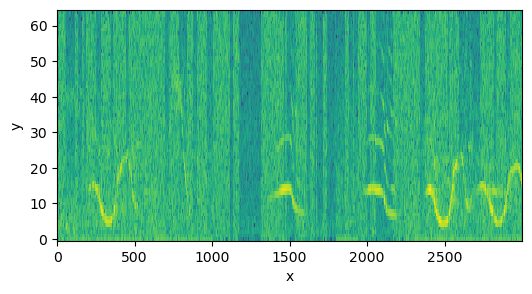

In [53]:
useful.vis_helper(np.concatenate(val.features)[:3000])

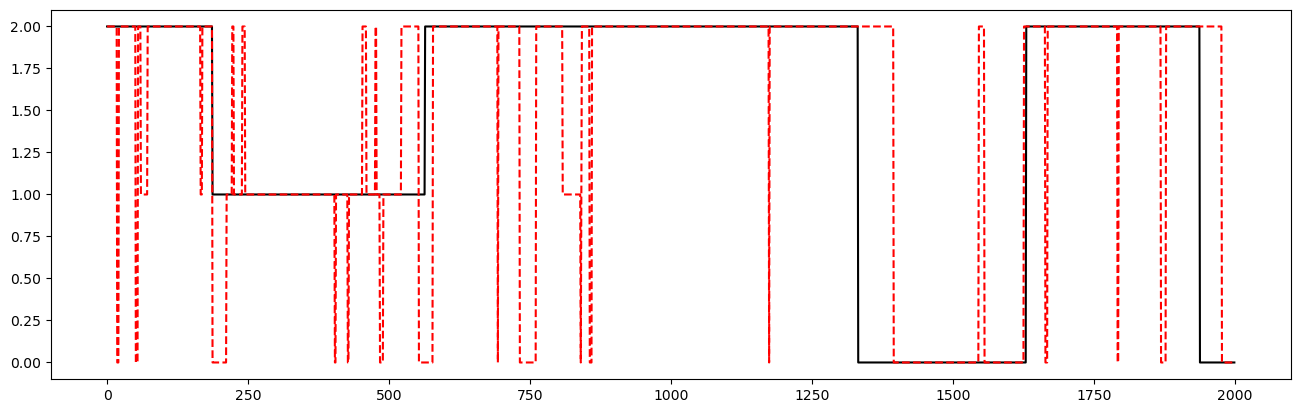

In [54]:
# val subset

subset_len = 2000

val_true_subset = np.concatenate(val.feature_labels)[:subset_len]
val_pred_subset = val_pred_fhmm[:subset_len]
val_features_subset = np.concatenate(val.features)[:subset_len]

import matplotlib.pyplot as plt
plt.plot(val_true_subset, c='black')
plt.plot(val_pred_subset, '--', c='red')
# useful.vis_helper(val_features_subset)

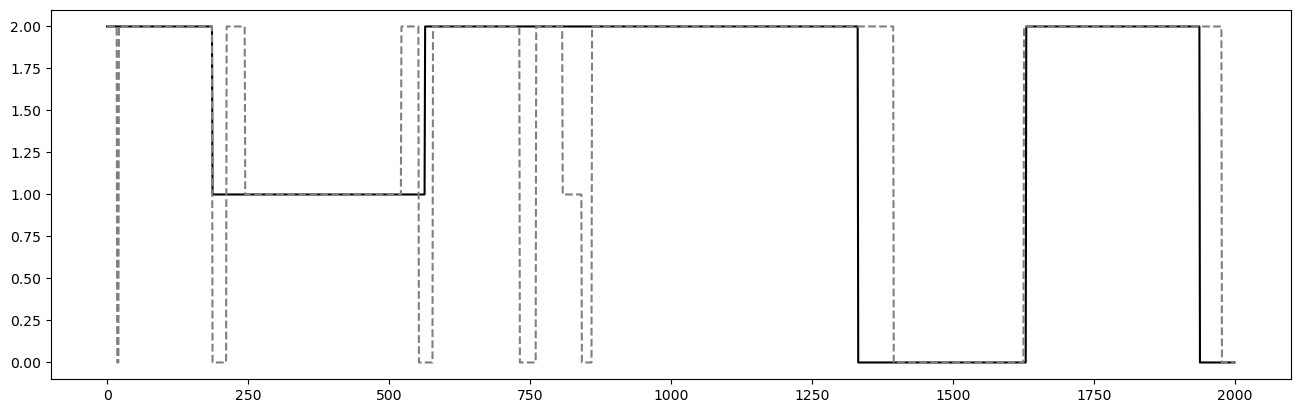

In [57]:
importlib.reload(useful)

val_pred_subset_smoothed = useful.smooth_labels(val_pred_subset)
plt.plot(val_true_subset, c='black')
# plt.plot(useful.smooth_labels(val_pred_subset_smoothed), '--', c='red')
plt.plot(val_pred_subset_smoothed, '--', c='grey')

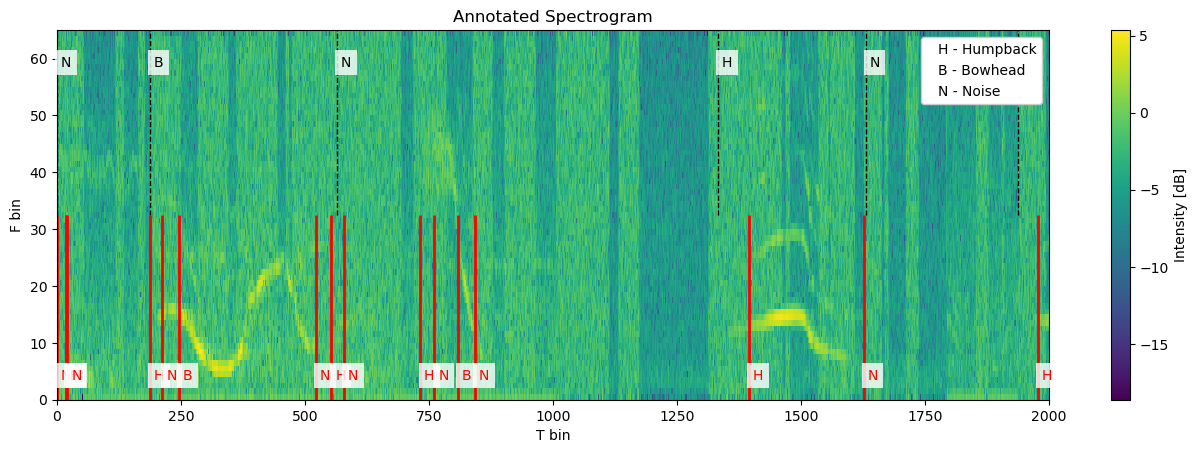

In [58]:
label_to_abr = {
    0: 'H',
    1: 'B',
    2: 'N'
}

useful.plot_spectrogram(val_features_subset, val_true_subset, useful.smooth_labels(val_pred_subset_smoothed), label_to_type, label_to_abr)

# Testing

In [46]:
# adjustment for sliding windows and noise introduction

importlib.reload(useful)

train_noise_indices = train.sample_labels == signal_types_labels['noise']
train_noise_samples = [item for item, condition in zip(train.samples, train_noise_indices) if condition]

# adjust samples so that there are more noise samples, and in the middle there is a long break
new_test_labels = []
new_test_samples = []

for i in range(len(test.samples)):
    new_test_samples.append(test.samples[i])
    new_test_labels.append(test.sample_labels[i])
    if int(test.sample_labels[i]) is not signal_types_labels['noise']:
        new_test_samples.append(train_noise_samples[np.random.randint(0,len(train_noise_samples))])
        new_test_samples.append(train_noise_samples[np.random.randint(0,len(train_noise_samples))])
        new_test_labels.append(signal_types_labels['noise'])
        new_test_labels.append(signal_types_labels['noise'])
    if i == len(test.samples) // 2:
        new_test_samples.append(train_noise_samples[np.random.randint(0,len(train_noise_samples))])
        new_test_samples.append(train_noise_samples[np.random.randint(0,len(train_noise_samples))])
        new_test_samples.append(train_noise_samples[np.random.randint(0,len(train_noise_samples))])
        new_test_samples.append(train_noise_samples[np.random.randint(0,len(train_noise_samples))])
        new_test_labels.append(signal_types_labels['noise'])
        new_test_labels.append(signal_types_labels['noise'])
        new_test_labels.append(signal_types_labels['noise'])
        new_test_labels.append(signal_types_labels['noise'])

test_new = useful.SampleHolder(new_test_samples, [int(num) for num in new_test_labels])

In [47]:
test_new.features = []
test_noise_samples = []
test_noise_features = []

for i in range(len(test_new.samples)):
    if i < len(test_new.samples) // 2:
         feature = get_feature(test_new.samples[i])
    else:
        # ---- noise / reverb adjustments ---- START
        noise_sample = get_noise_for_sample(signal_avg_db, test_new.samples[i], 5, 5, 30)
        test_noise_samples.append(noise_sample)
        test_noise_features.append(get_feature(noise_sample))
        adjusted_sample = test_new.samples[i] + noise_sample
        # ---- noise / reverb adjustments ---- END
        feature = get_feature(adjusted_sample)
    test_new.features.append(feature)
test_new.update_feature_labels()

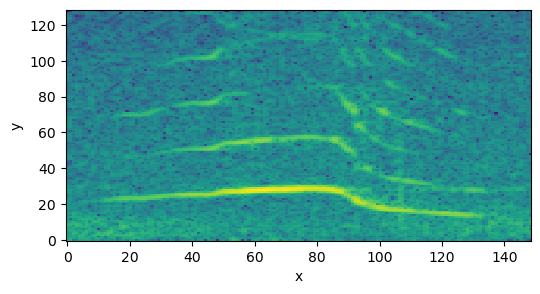

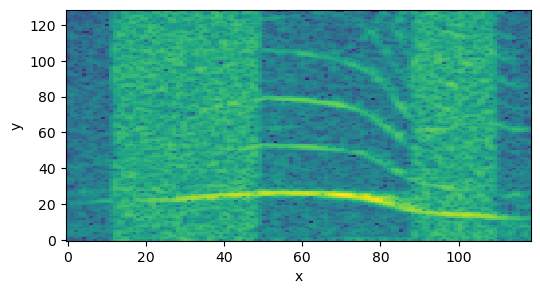

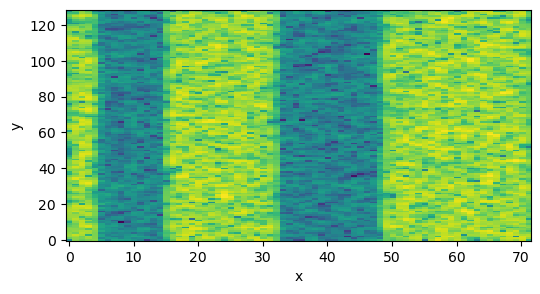

In [50]:
useful.vis_helper(train.features[5])
useful.vis_helper(test_new.features[-3])
useful.vis_helper(test_noise_features[0])

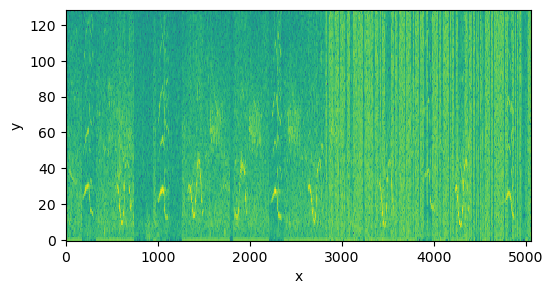

{'acc': 0.49928109273903665, 'tpr': 0.360093896713615, 'fpr': 0.046012269938650305}


In [113]:
test_features_concat = np.concatenate(test_new.features)
_, test_pred, test_log_prob = combined_model.decode_hmmlearn(test_features_concat)
useful.vis_helper(test_features_concat)
accuracy = useful.perf_measure(np.concatenate(test_new.feature_labels), test_pred)
print(accuracy)
## use fhmm_dc from above trained on noise as well

In [106]:
noise_hmm = GaussianHMM(3, covariance_type='full', init_params='')
noise_hmm.fit(np.concatenate(test_noise_features))

fhmms = {}
for key in hmms:
    fhmm = FactorialHMM(hmms[key], noise_hmm)
    fhmms[key] = fhmm.hmm

combined_model_fhmm = dc.DecodeCombineGaussian([fhmm for fhmm in fhmms.values()])

_, val_pred_fhmm, val_log_prob_fhmm = combined_model_fhmm.decode_hmmlearn(np.concatenate(test_new.features)[3000:])
accuracy = useful.perf_measure(np.concatenate(test_new.feature_labels)[3000:], val_pred_fhmm)
print(accuracy)

{'acc': 0.7852998065764023, 'tpr': 0.7569230769230769, 'fpr': 0.16666666666666666}


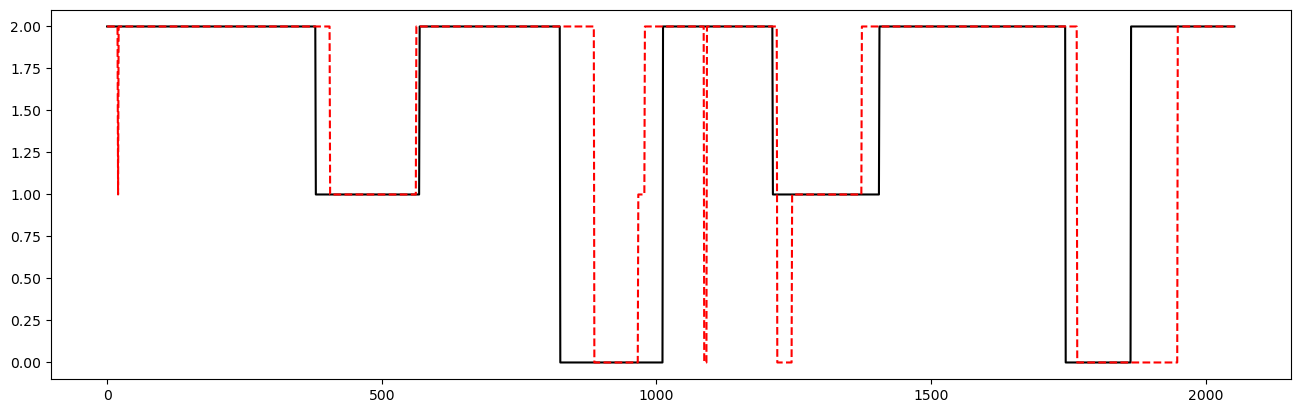

In [104]:
plt.plot(np.concatenate(test_new.feature_labels)[3000:], c='black')
plt.plot(useful.smooth_labels(val_pred_fhmm), '--', c='red')

In [114]:
# insert for adaptive noise handling
# update noise hmm to bayesian / HDP ?

class NoiseAdaptiveHMM:
    def __init__(self, dc_model: dc.DecodeCombineGaussian, signal_hmms, n_hmm: GaussianHMM):
        self.dc_model: dc.DecodeCombineGaussian = dc_model
        self.signal_hmms = signal_hmms  # dict with hmms inside
        self.n_hmm = n_hmm

    def update_model(self, new_noise_features):
        # new noise features, aim is to update fhmms and then dc_model
        self.n_hmm.fit(new_noise_features)

        updated_fhmms = {}
        for key in self.signal_hmms:
            updated_fhmm = FactorialHMM(hmms[key], self.n_hmm)
            updated_fhmms[key] = updated_fhmm.hmm

        self.dc_model = dc.DecodeCombineGaussian([u_fhmm for u_fhmm in updated_fhmms.values()])

        print('model updated to changing noise conditions')


def sliding_windows(data, window_size, step_size, na_hmm: NoiseAdaptiveHMM, mean_log_prob, threshold = 1.2, re_train_buffer=10):
    output = {
        'noise_data': []
    }
    windows = []
    log_probs = []
    std_probs = []
    states_decoded = np.zeros(len(data))
    window_indices = []

    train_counter = 0


    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i+window_size, :]

        # do stuff here
        _, test_pred, log_prob = na_hmm.dc_model.decode_hmmlearn(window)
        log_probs.append(log_prob)
        states_decoded[i:i+window_size] = test_pred
        windows.append(window)
        window_indices.append(i)
        std_probs.append(np.std(log_probs[-3:]))

        # avoid re-training a lot
        if train_counter > 0:
            train_counter -= 1

        # if likelihood drops bellow threshold then re-train noise hmm and update other hmms
        # maybe don't compare to complete std mean here ?
        if np.mean(log_probs[-10:]) < mean_log_prob * threshold and std_probs[-1] < np.mean(std_probs) and train_counter == 0:
            # use last 3 windows to train noise hmm
            # data[i:i + (step_size * 3)]
            start_index = window_indices[-3]
            noise_data = data[start_index:start_index + (step_size * 10)]
            na_hmm.update_model(noise_data)

            output['noise_data'].append(noise_data)

            # start buffer to avoid a lot of re-training
            train_counter = re_train_buffer

    output['windows'] = np.array(windows)
    output['prob'] = log_probs
    output['states'] = states_decoded
    return output

# Define sliding window parameters
window_size = 200
step_size = 50
my_na_hmm = NoiseAdaptiveHMM(combined_model, hmms, noise_hmm)
out = sliding_windows(test_features_concat, window_size, step_size, my_na_hmm, -50000, 1.2)
windows_states = out['states']

model updated to changing noise conditions


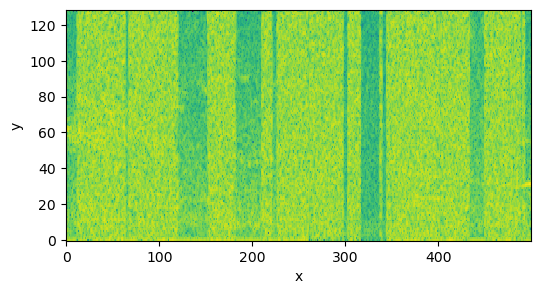

In [59]:
useful.vis_helper(out['noise_data'][0])

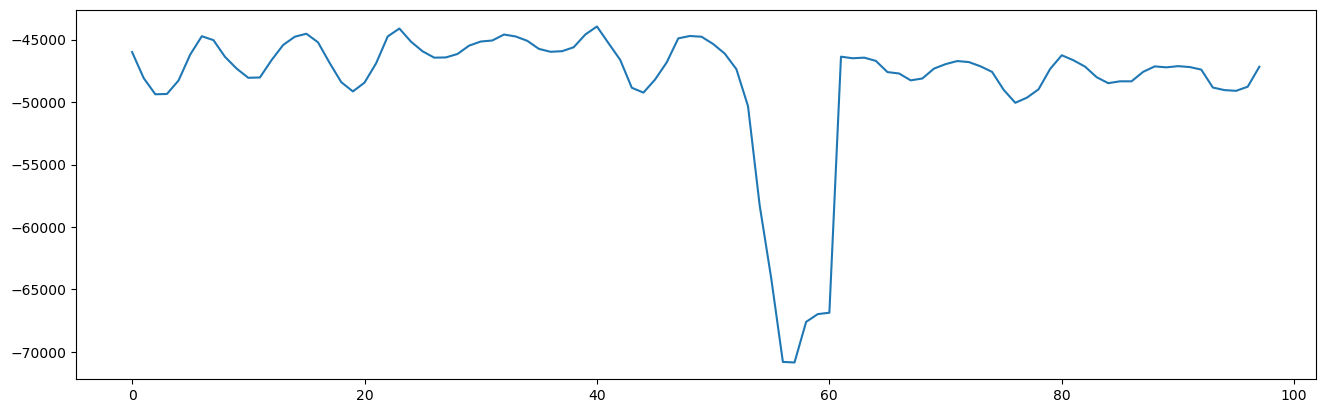

In [115]:
# close_test = np.isclose(windows_states, test_pred[:len(windows_states)])
plt.plot(out['prob'])

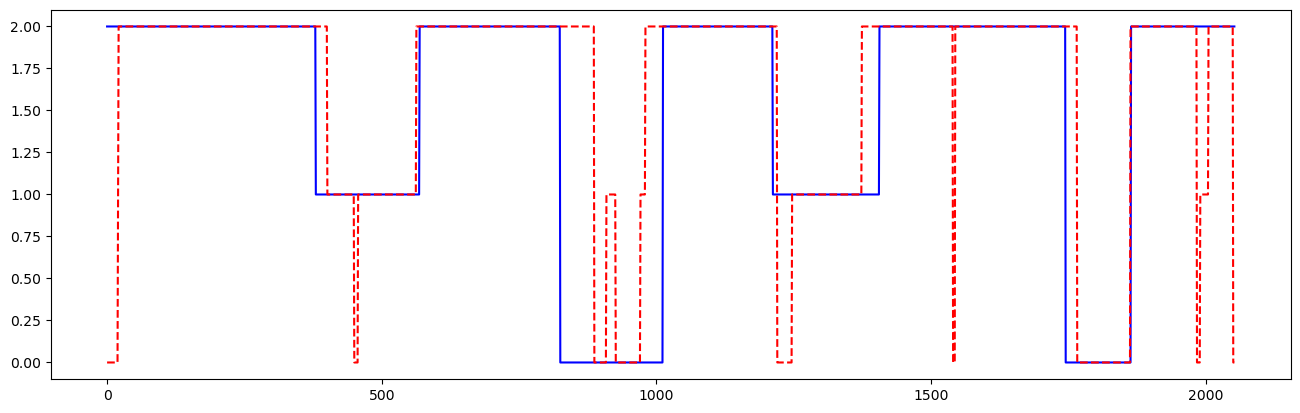

In [117]:
plt.plot(np.concatenate(test_new.feature_labels)[3000:], c='b')
plt.plot(useful.smooth_labels(windows_states[3000:]), '--', c='r')
# plt.plot(useful.smooth_labels(windows_states[3000:]), '--', c='g')

In [119]:
accuracy = useful.perf_measure(np.concatenate(test_new.feature_labels)[3000:], useful.smooth_labels(windows_states[3000:]))
print(accuracy)

{'acc': 0.8036036036036036, 'tpr': 0.8080229226361032, 'fpr': 0.20388349514563106}


In [34]:

smoothed_labels = useful.smooth_labels(test_pred_subset)
# print("Original Labels:", labels)
# print("Smoothed Labels:", smooth_labels(labels))

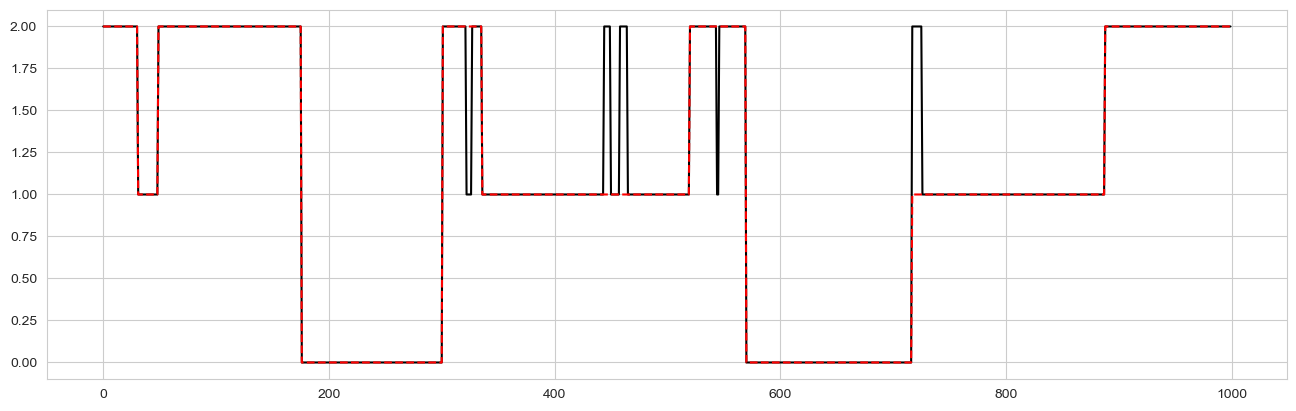

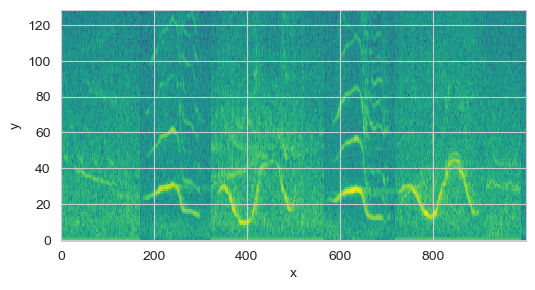

In [35]:
import matplotlib.pyplot as plt
plt.plot(test_pred_subset, c='black')
plt.plot(smoothed_labels, '--', c='red')
useful.vis_helper(test_features_concat_subset)

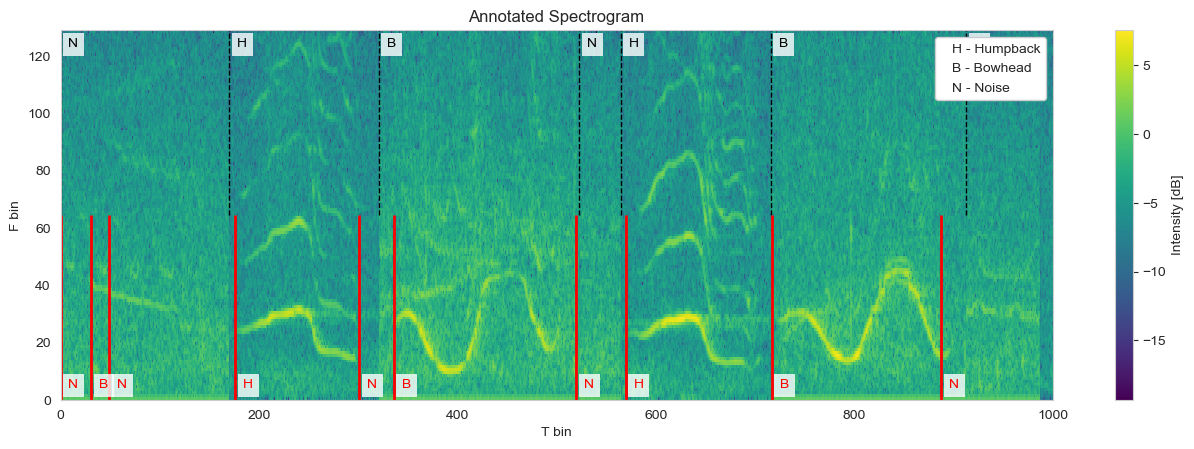

In [36]:
# plot spectrogram showing models and given annots,
importlib.reload(useful)

label_to_abr = {
    0: 'H',
    1: 'B',
    2: 'N'
}

useful.plot_spectrogram(test_features_concat_subset, np.concatenate(test.feature_labels)[:1000], smoothed_labels, label_to_type, label_to_abr)